# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import lya_theory
import likelihood

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True)
zs=data.z

In [3]:
# load P1D emulator
emu=linear_emulator.LinearEmulator(verbose=False)

setup interpolator for coefficient 0
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-1.18323575]
setup interpolator for coefficient 1
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.6323589]
setup interpolator for coefficient 2
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.29370814]
setup interpolator for coefficient 3
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.1279153]
setup interpolator for coefficient 4
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.01945575]


In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)
# for this simple test, just use fiducial cosmology
theory.set_cosmo_model(linP_model=theory.cosmo.linP_model_fid)
linP_Mpc_params=theory.cosmo.get_linP_Mpc_params()

Note: redshifts have been re-sorted (earliest first)
use default mean flux model
use default thermal model


In [5]:
# specify free parameters in likelihood
#free_parameters=['ln_tau_0','ln_tau_1']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0']
#free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0']
free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_T0_1','ln_gamma_0','ln_gamma_1']

In [6]:
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
likelihood setup with 6 free parameters
6 free parameters


In [7]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414
ln_tau_1 3.18
ln_T0_0 9.21034037198
ln_T0_1 0.0
ln_gamma_0 0.336472236621
ln_gamma_1 0.0


In [8]:
like.go_silent()

### Setup MCMC to call this function

In [9]:
def log_prob(values,like,linP_Mpc_params,verbose=False):
    test_log_prob=like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [10]:
def setup_walkers(ndim,nwalkers,like,linP_Mpc_params,verbose=False):
    print('setup %d walkers with %d dimensions'%(nwalkers,ndim))
    p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))
    # make sure that all walkers are within the convex hull
    for iw in range(nwalkers):
        walker=p0[iw]
        if verbose: print(iw,'walker',walker)
        test=log_prob(walker,like,linP_Mpc_params)
        while (test == -np.inf):
            if verbose: print(iw,'bad walker',walker)
            walker = np.random.rand(ndim)
            if verbose: print(iw,'try walker',walker)
            test=log_prob(walker,like,linP_Mpc_params)
        if verbose: print(iw,'good walker',walker,' log_prob=',test)
        p0[iw]=walker
    return p0

In [11]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=len(like.free_params)
# setup initial walkers
nwalkers = 50

In [12]:
p0=setup_walkers(ndim,nwalkers,like,linP_Mpc_params)

setup 50 walkers with 6 dimensions


In [13]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like,linP_Mpc_params])

In [14]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 200)
print('finished burn-in at',pos[0],prob[0])

finished burn-in at [ 0.44667343  0.60592359  0.59517625  0.91924271  0.7745493   0.58091731] -1170.67650246


In [15]:
# reset and run actual chains
sampler.reset()
nsteps=1000
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 100 == 0:
        print(i,result[0][0])

0 [ 0.43768456  0.62522516  0.59878543  0.9088935   0.7779702   0.5751588 ]
100 [ 0.44412991  0.60778939  0.5895201   0.9304737   0.77019341  0.5866855 ]
200 [ 0.43972489  0.63612226  0.58721763  0.92536287  0.76665374  0.58004871]
300 [ 0.4385134   0.62511984  0.59664908  0.9098011   0.77131951  0.58102762]
400 [ 0.42731135  0.63064218  0.60262592  0.89897161  0.77326731  0.58094316]
500 [ 0.45522112  0.58690918  0.58472467  0.95004059  0.76639637  0.595953  ]
600 [ 0.45340595  0.61110635  0.58769502  0.94279097  0.76593424  0.59638035]
700 [ 0.45688648  0.59388467  0.58824754  0.93897387  0.76126826  0.6013018 ]
800 [ 0.46250194  0.5860969   0.58797095  0.94189949  0.76704032  0.59623986]
900 [ 0.44918426  0.60041622  0.58369203  0.95274783  0.78285742  0.57452721]


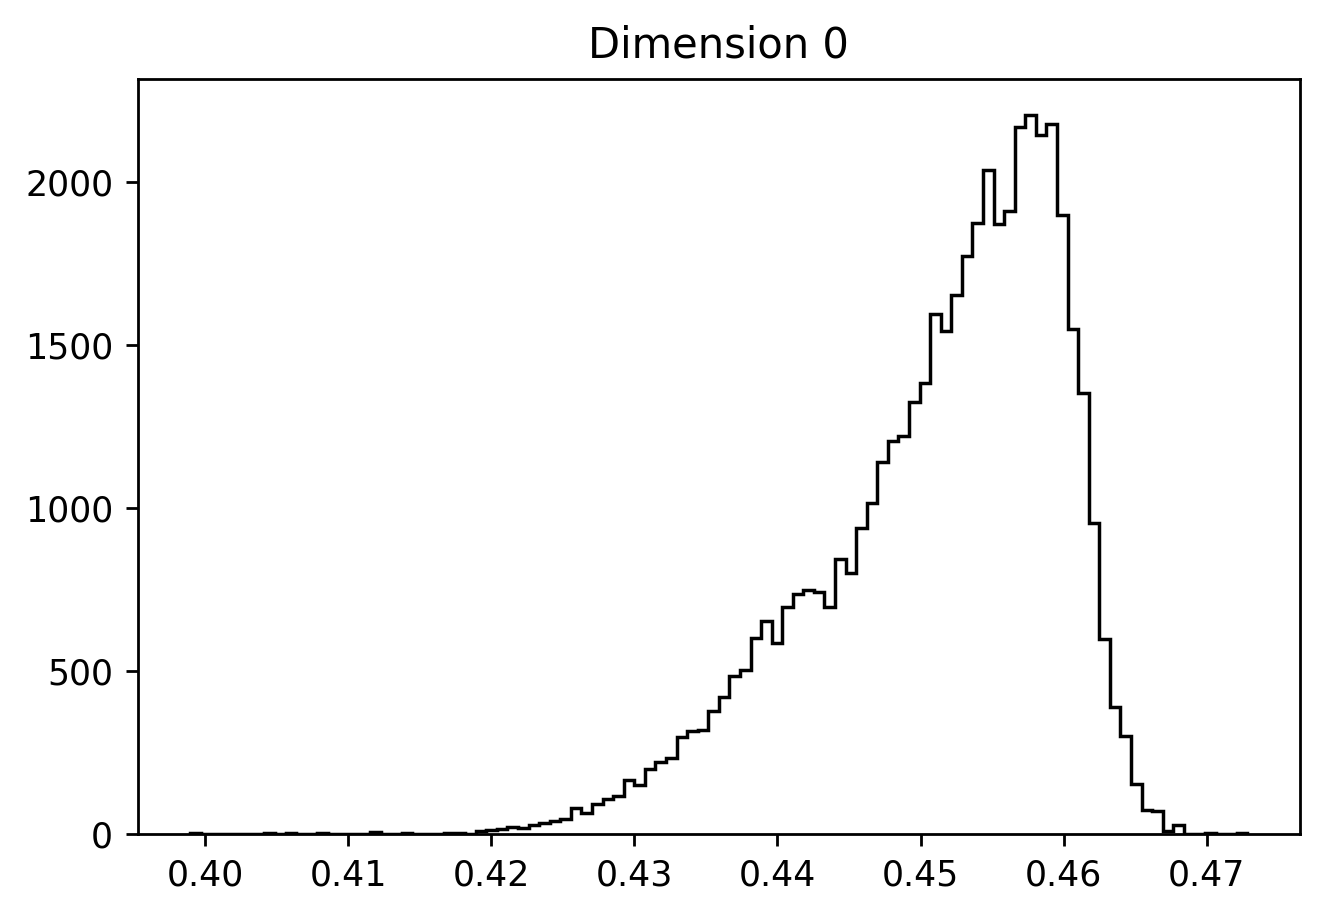

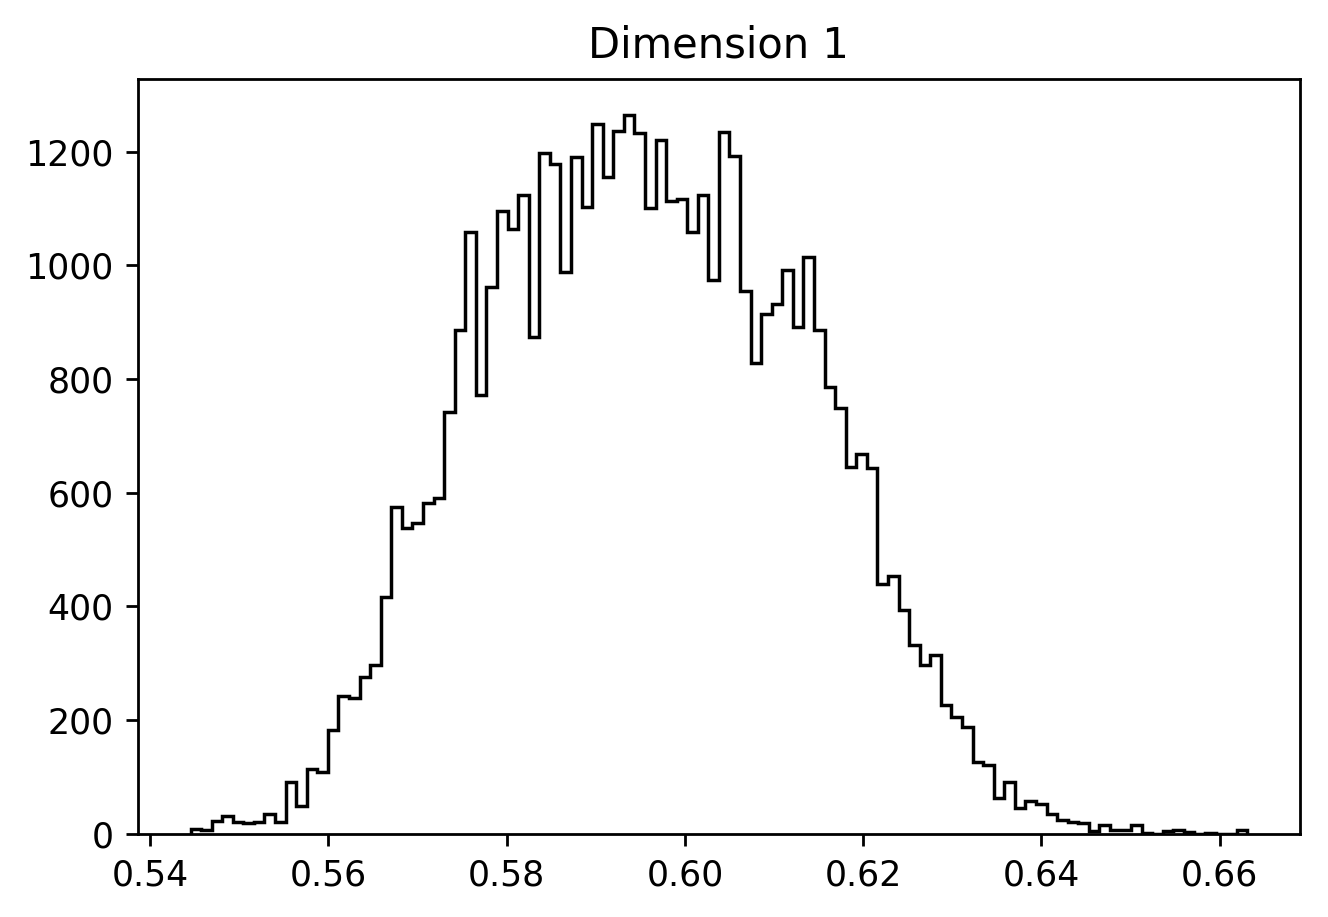

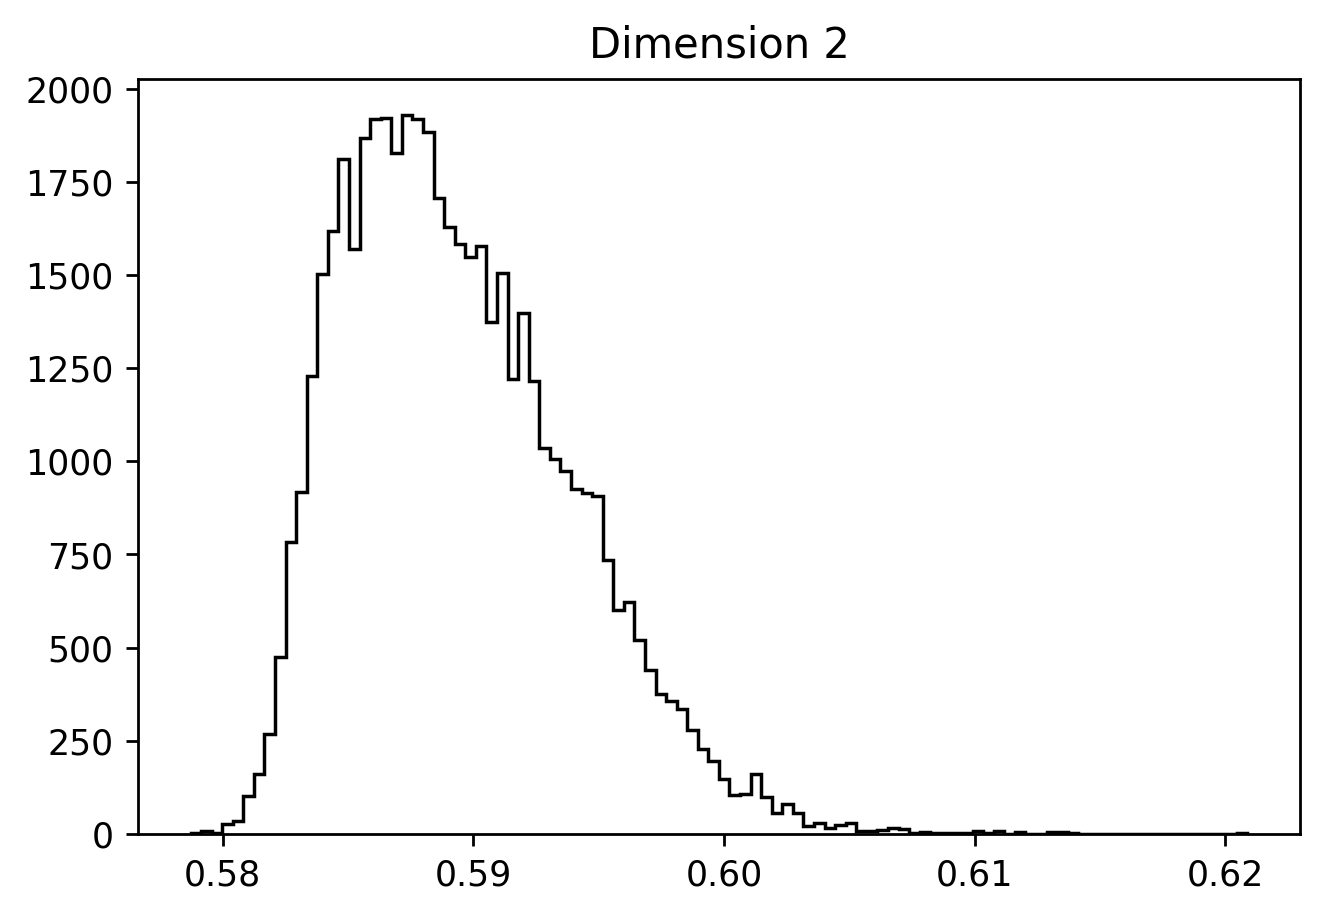

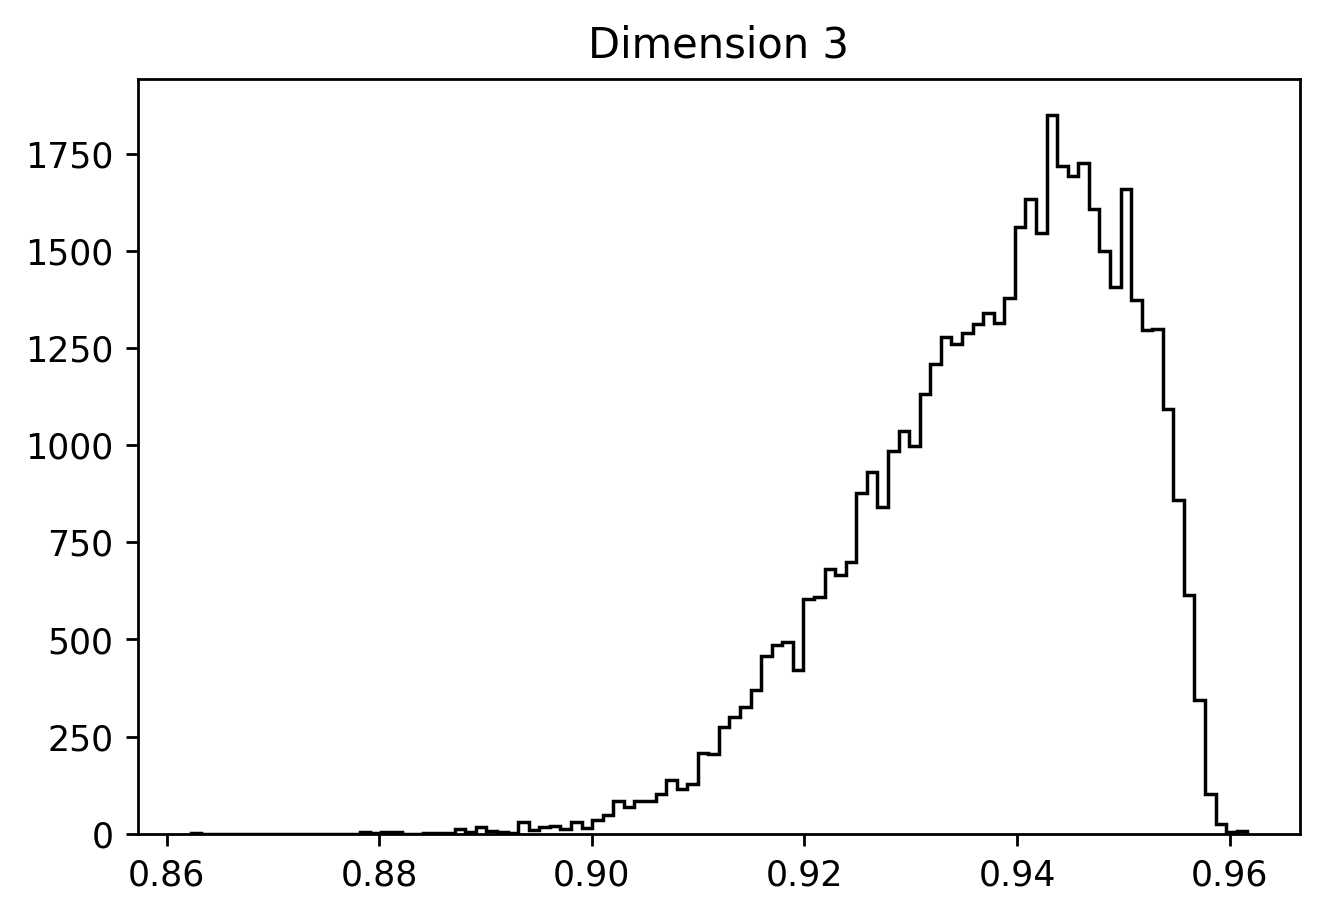

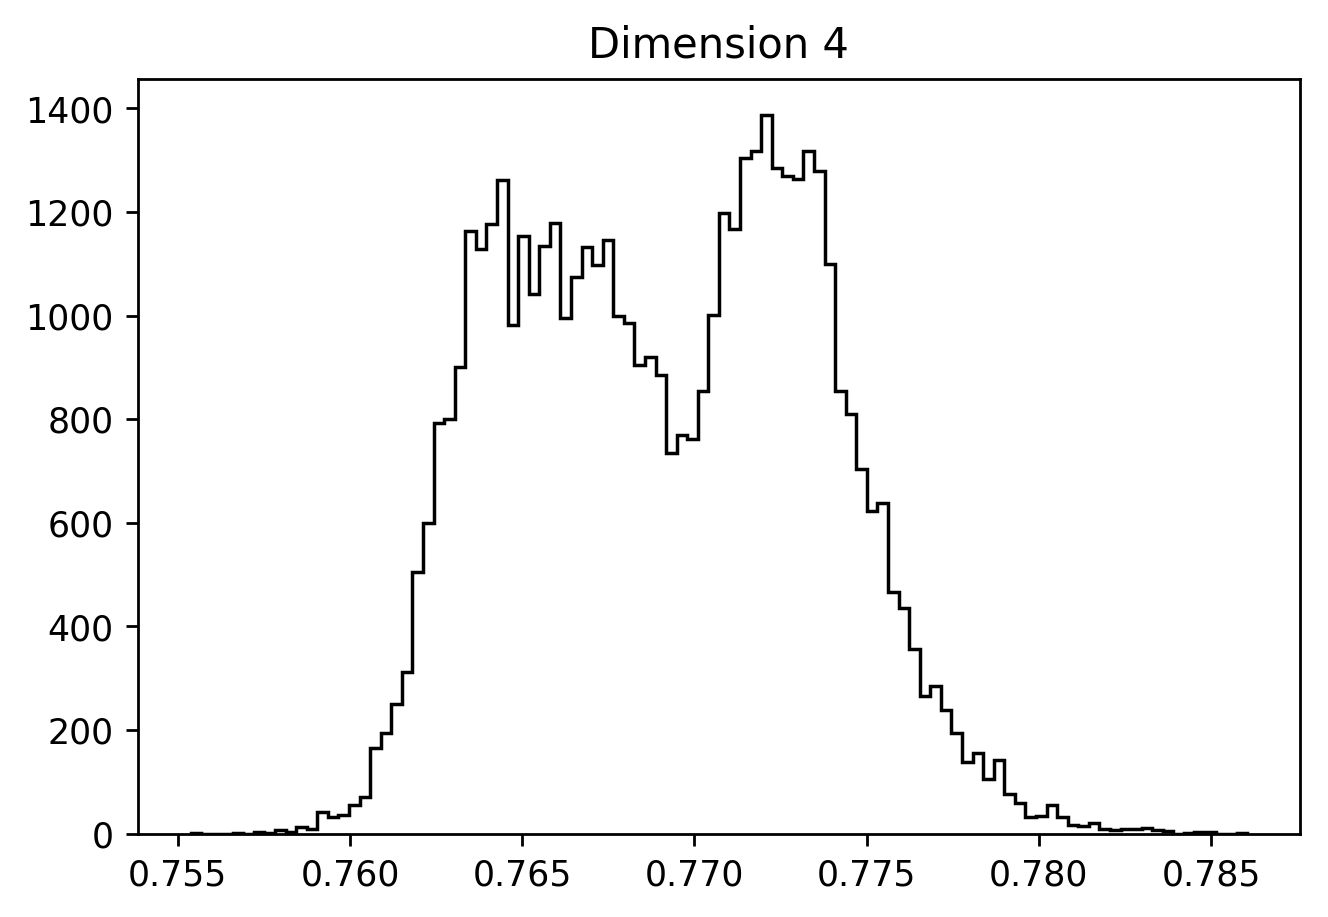

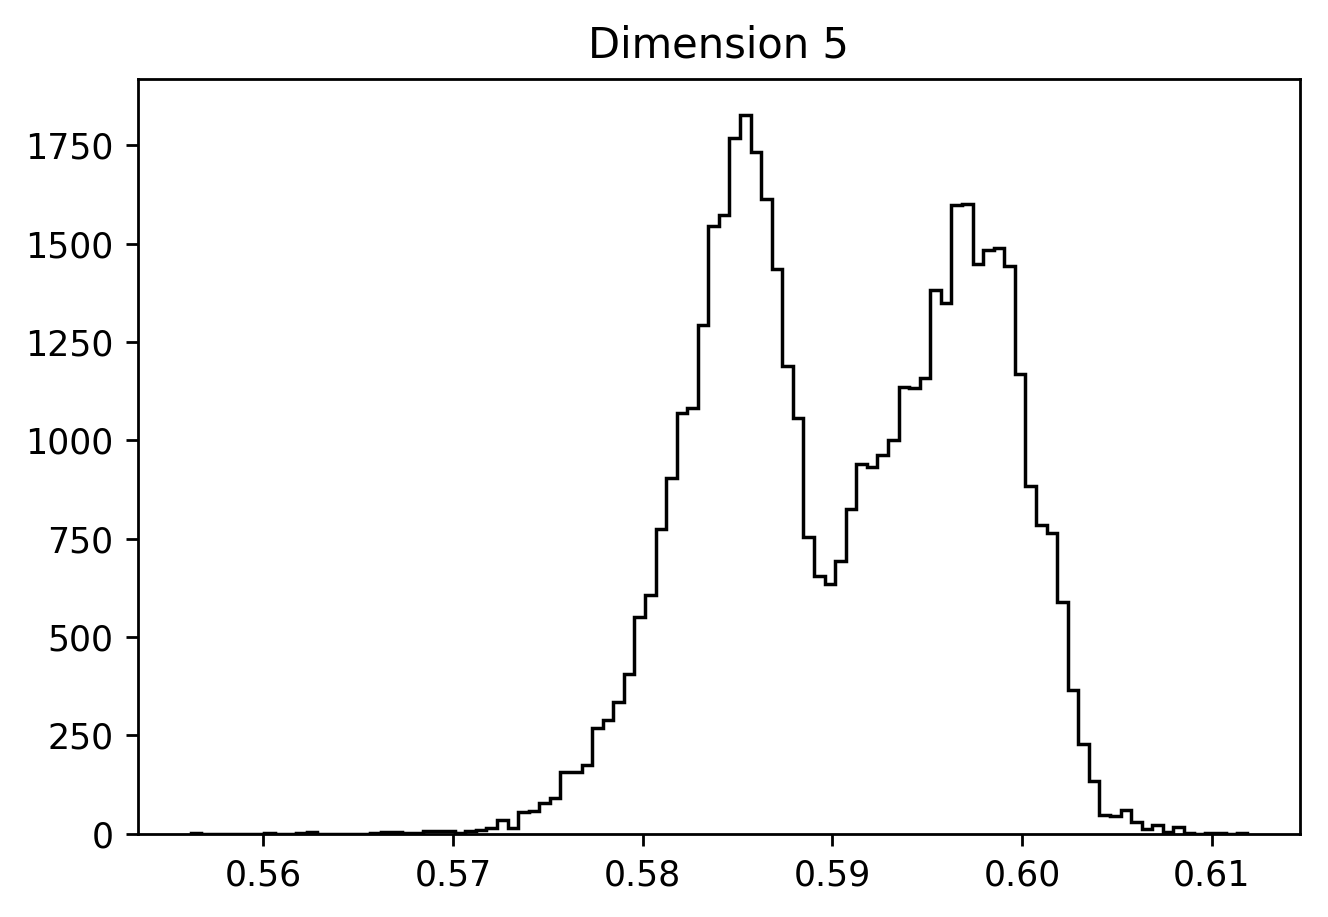

In [16]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.title("Dimension {0:d}".format(i))

In [17]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.428


### Use likelihood object to make several useful plots

In [18]:
# get mean of chain
mcmc_mean=np.mean(sampler.flatchain,axis=0)
print('mean point',mcmc_mean)

mean point [ 0.45128769  0.59564822  0.58938239  0.93769809  0.76916887  0.59065164]


In [19]:
like.update_parameters(mcmc_mean)

In [20]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.974356157287
ln_tau_1 4.19129644713
ln_T0_0 9.57322466847
ln_T0_1 1.75079236038
ln_gamma_0 0.474107761379
ln_gamma_1 0.181303289408


Text(0, 0.5, '<F>')

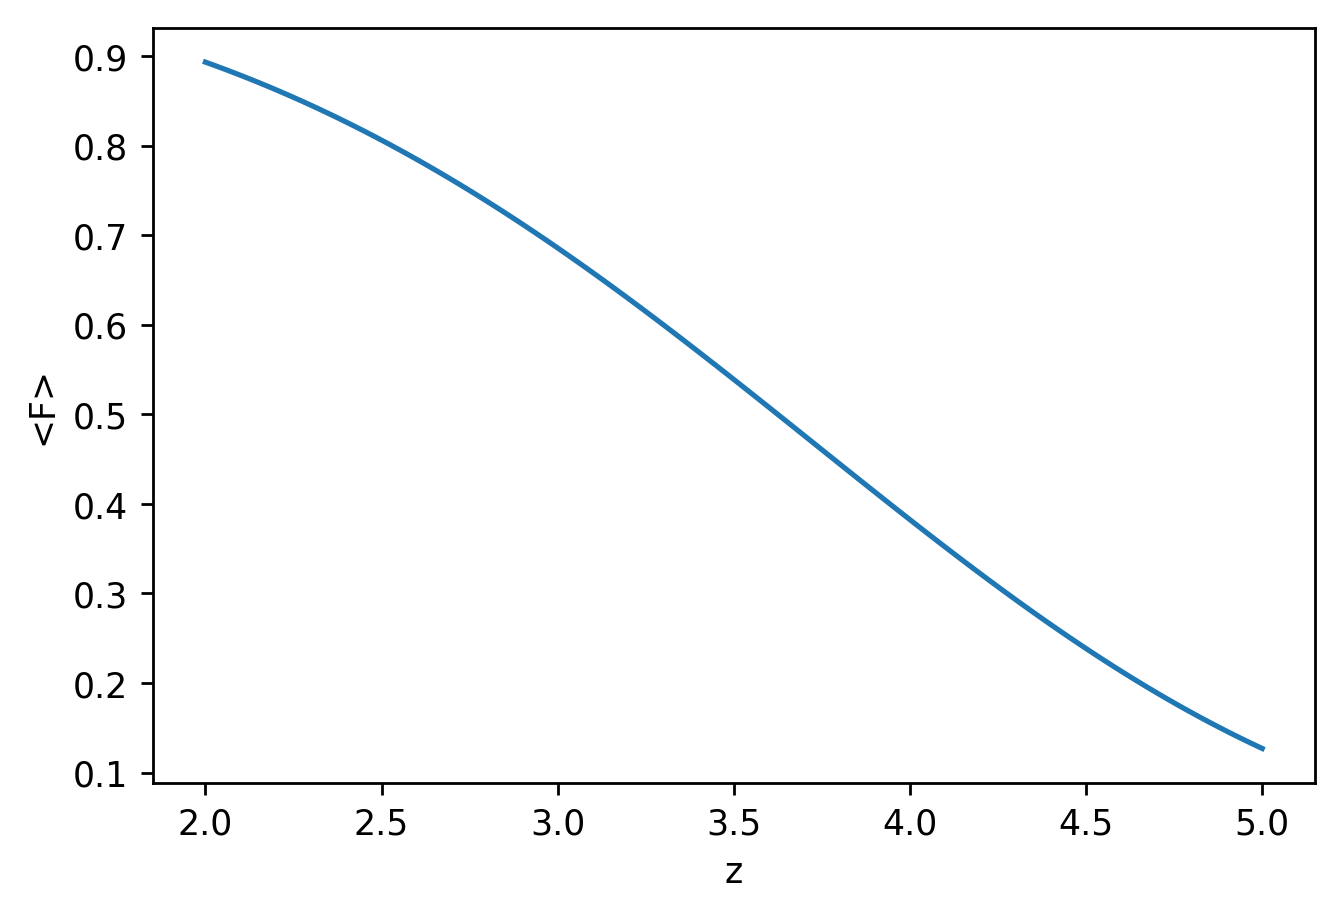

In [21]:
z=np.linspace(2.0,5.0,100)
mf=like.theory.mf_model.get_mean_flux(z)
plt.plot(z,mf)
plt.xlabel('z')
plt.ylabel('<F>')

Text(0, 0.5, '$T_0(z)$ [K]')

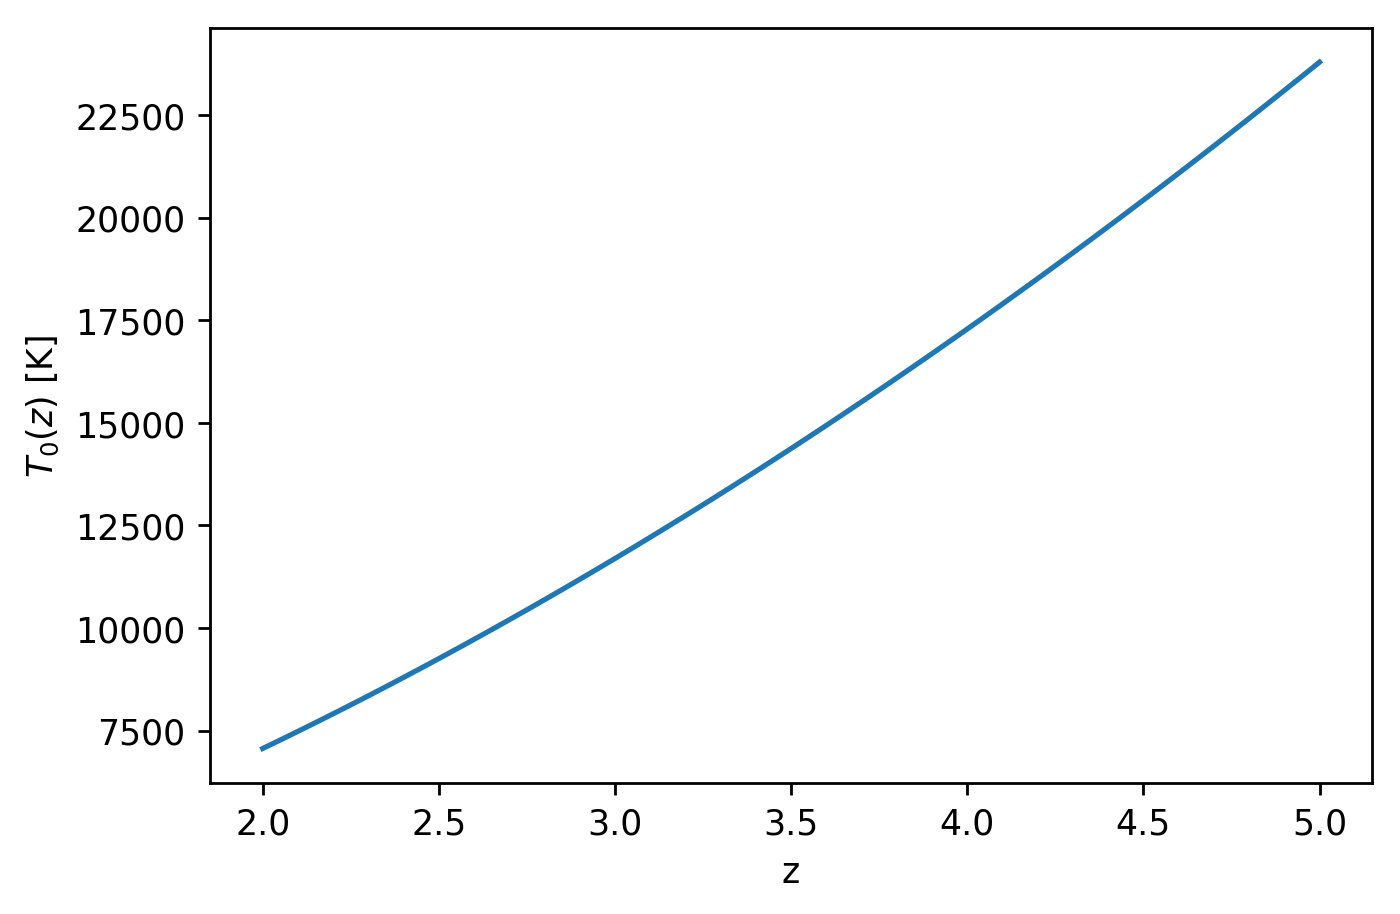

In [22]:
T0=like.theory.T_model.get_T0(z)
plt.plot(z,T0)
plt.xlabel('z')
plt.ylabel(r'$T_0(z)$ [K]')

Text(0, 0.5, '$\\sigma_T(z)$ [km/s]')

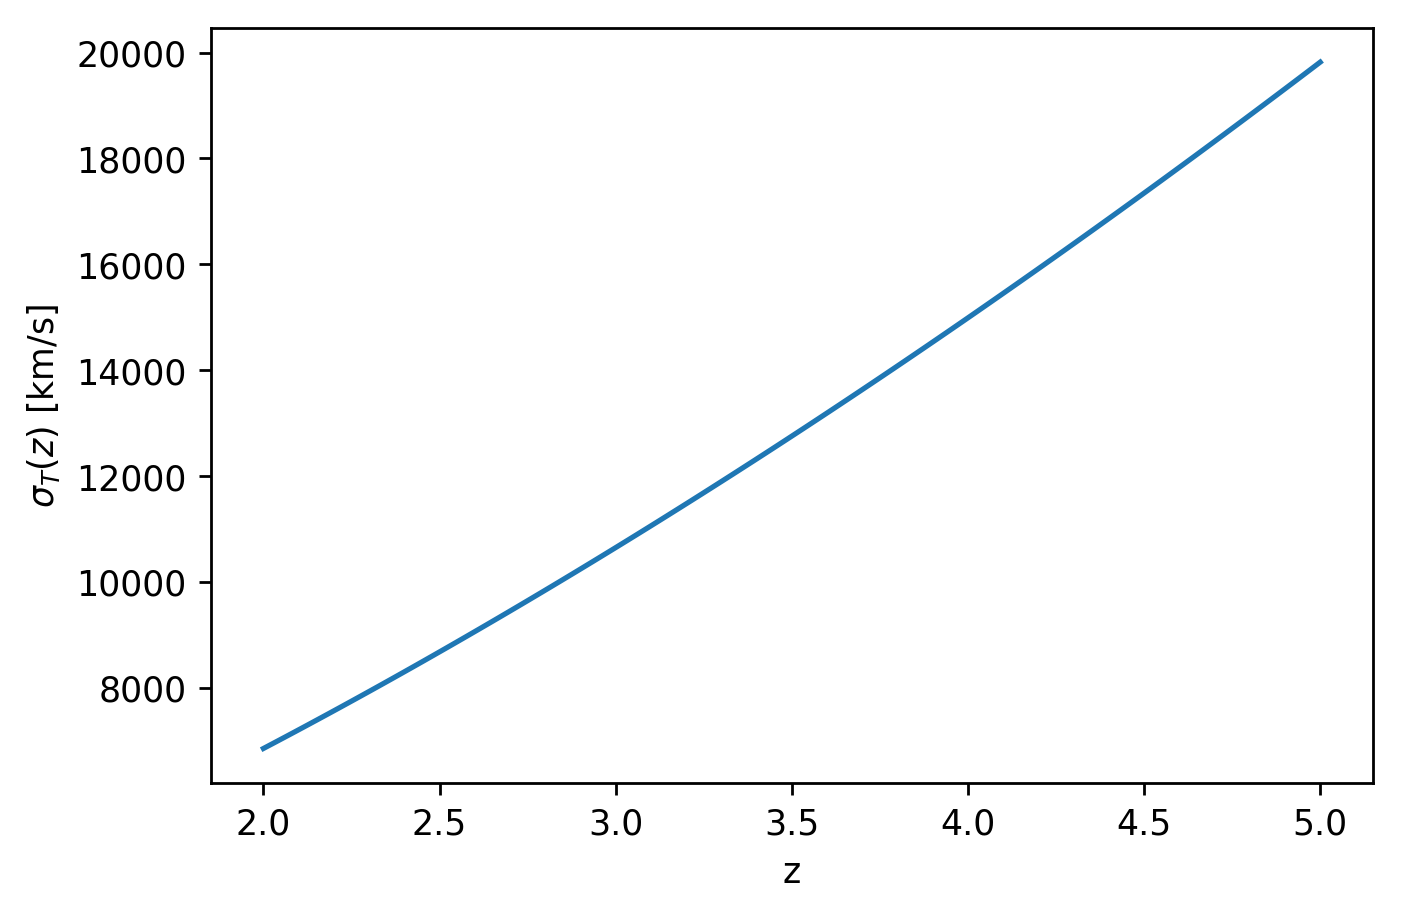

In [23]:
sigT=like.theory.T_model.get_sigT_kms(T0)
plt.plot(z,sigT)
plt.xlabel('z')
plt.ylabel(r'$\sigma_T(z)$ [km/s]')

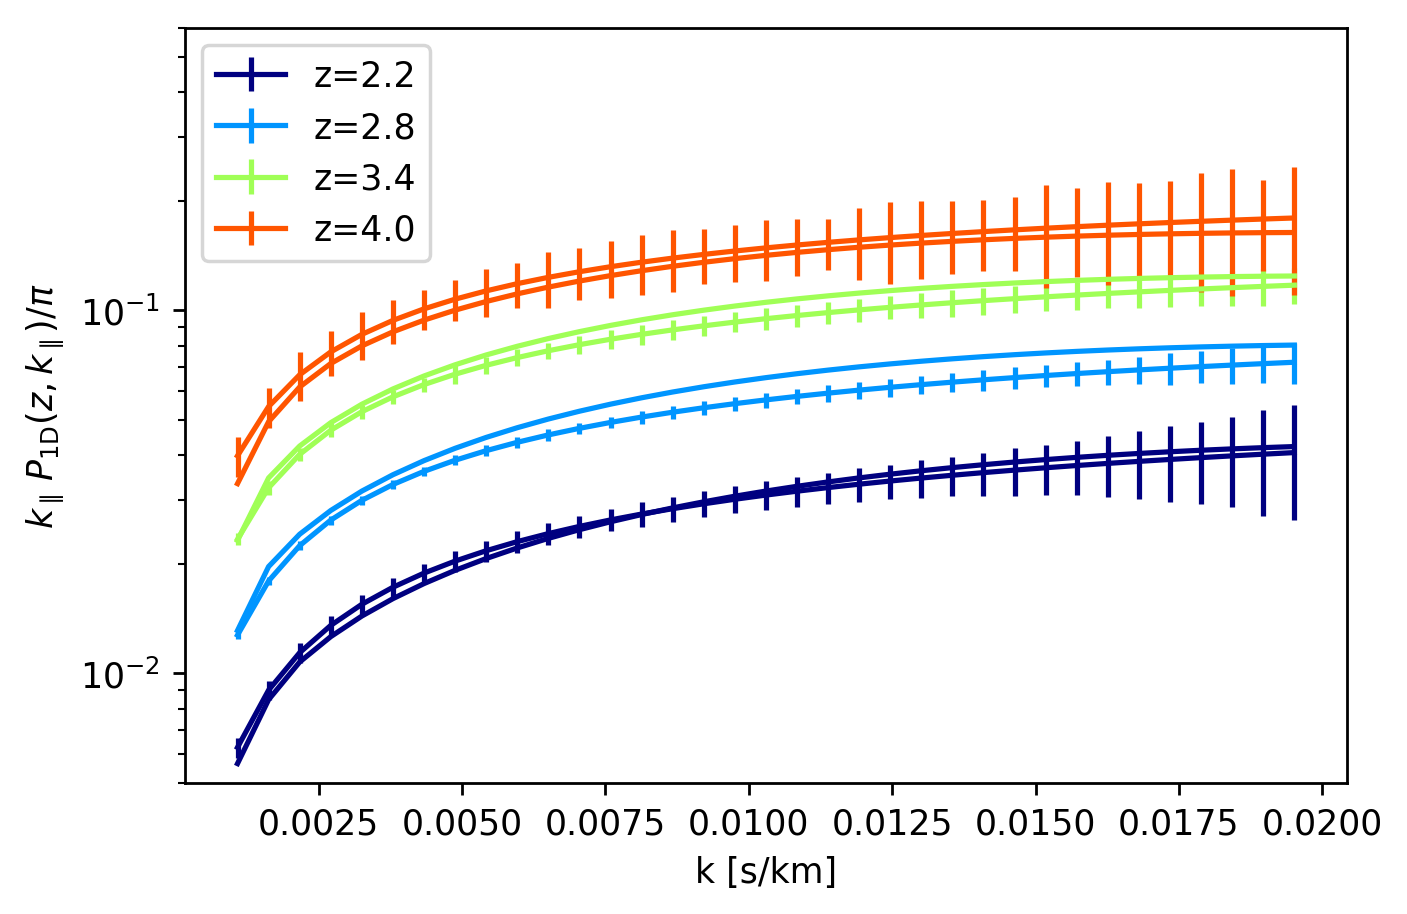

In [24]:
like.plot_p1d()

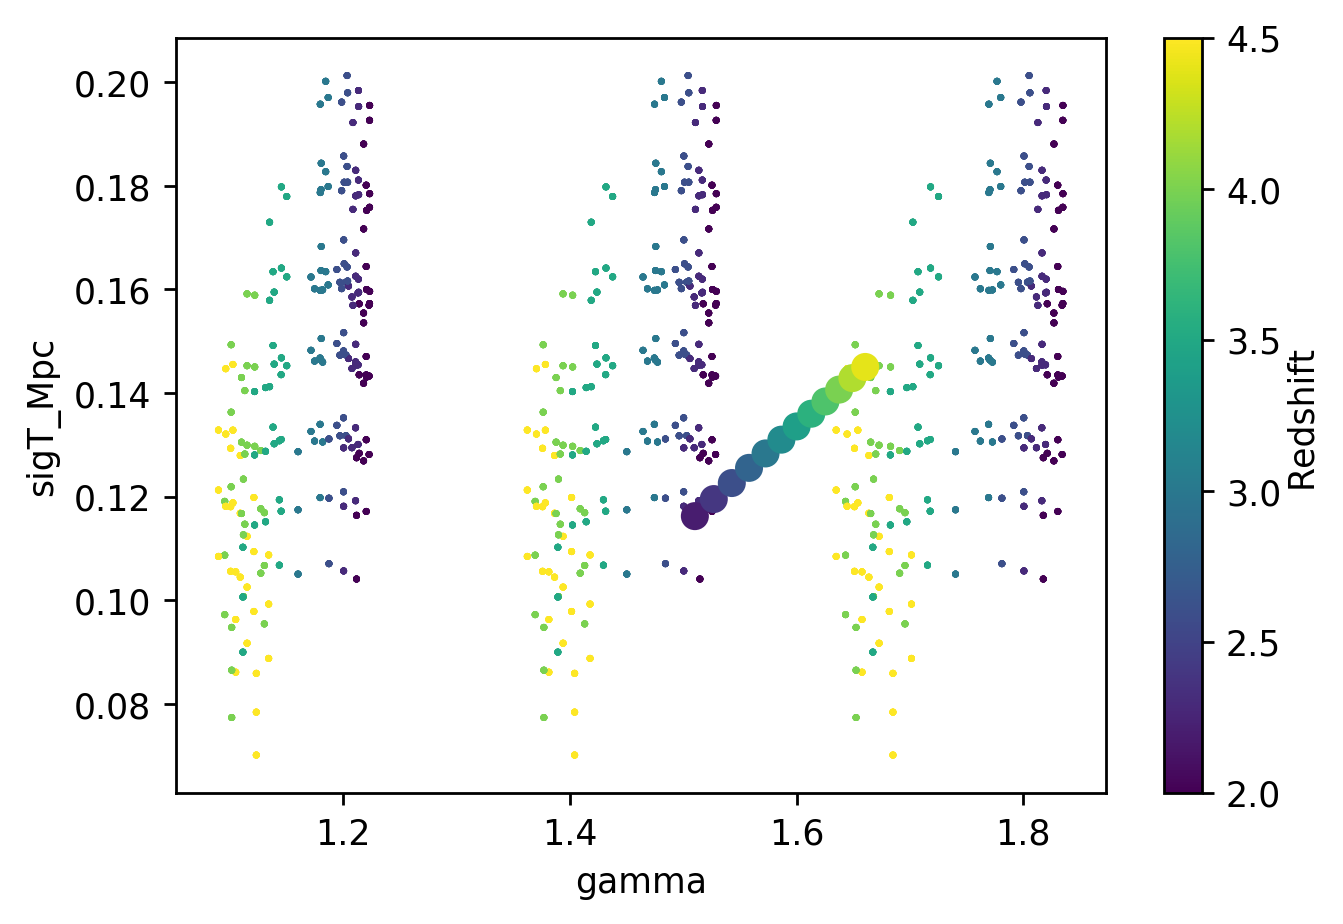

In [25]:
like.overplot_emulator_calls('gamma','sigT_Mpc',linP_Mpc_params=linP_Mpc_params)

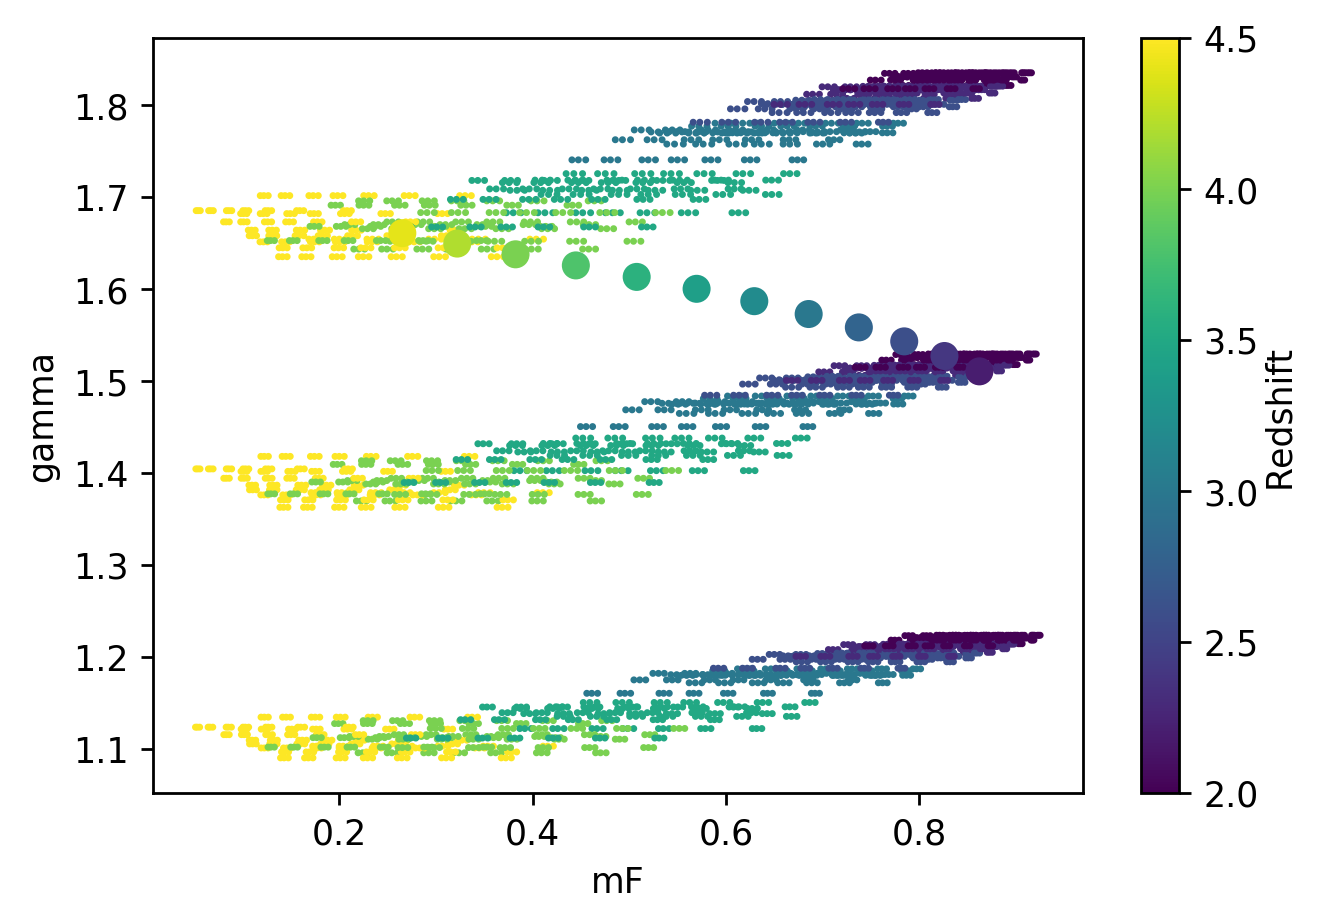

In [26]:
like.overplot_emulator_calls('mF','gamma',linP_Mpc_params=linP_Mpc_params)

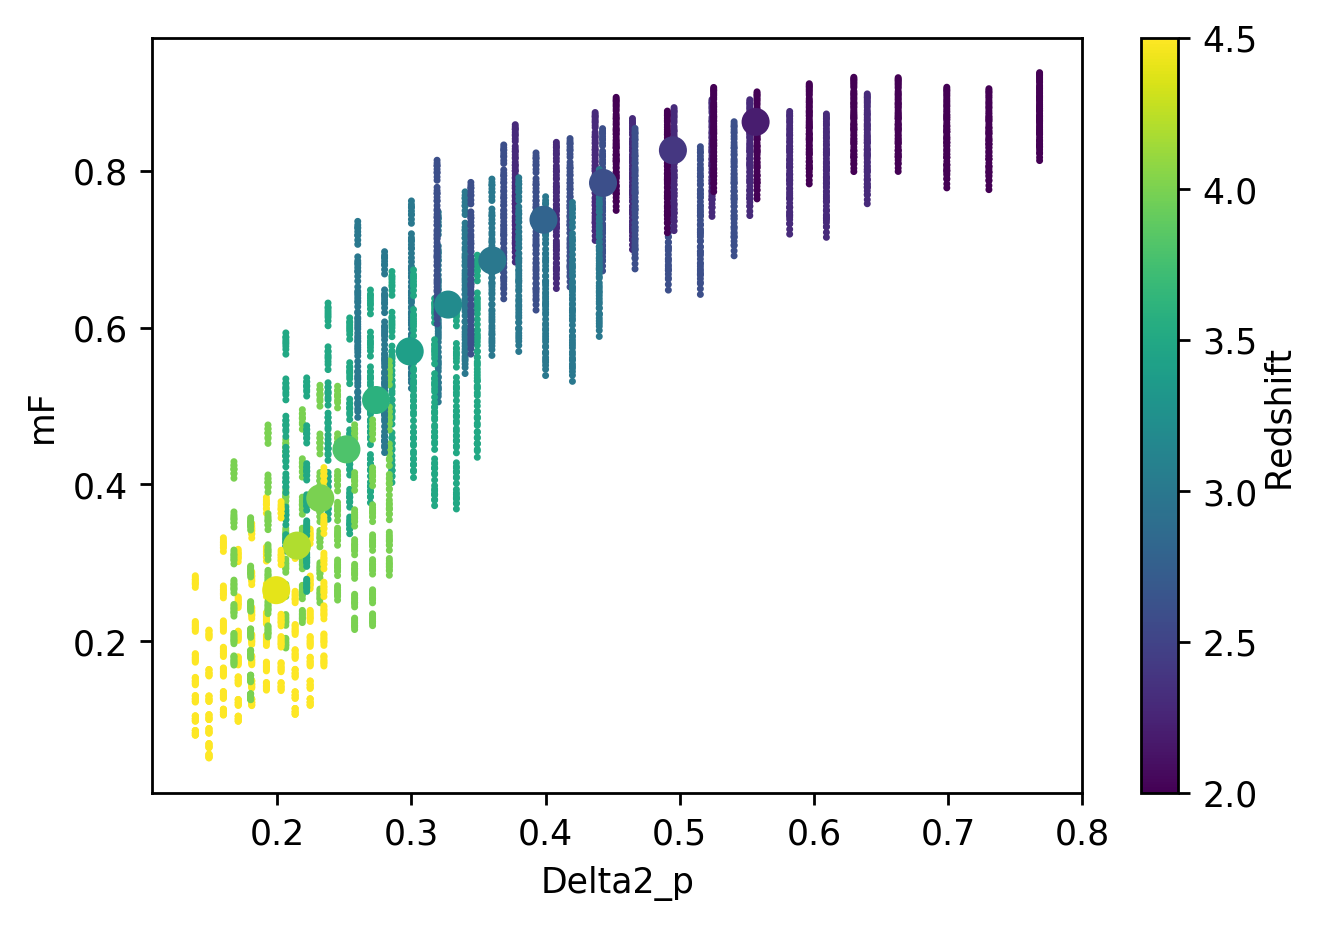

In [27]:
like.overplot_emulator_calls('Delta2_p','mF',linP_Mpc_params=linP_Mpc_params)

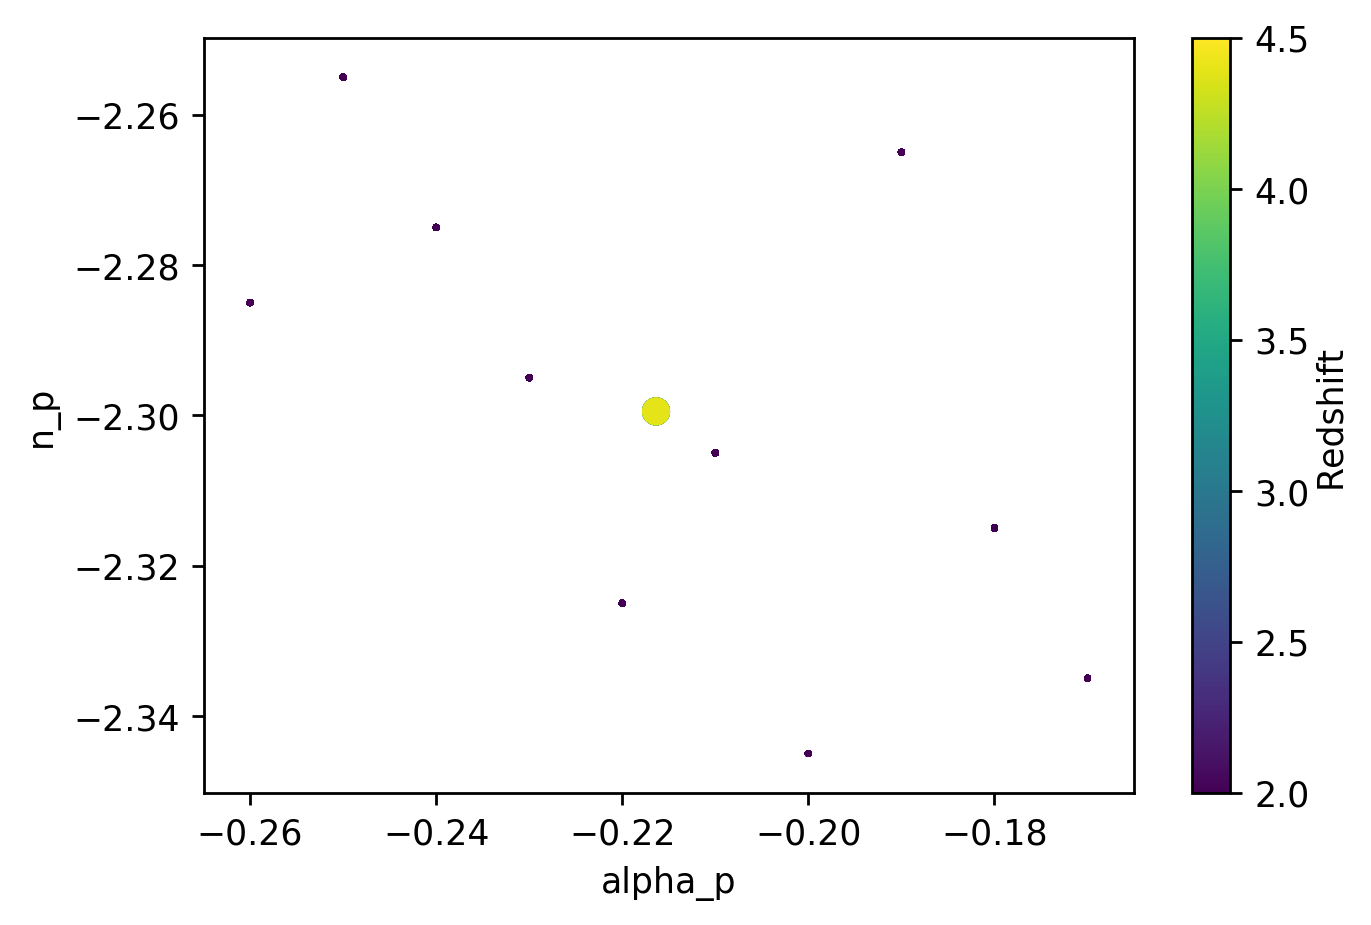

In [28]:
like.overplot_emulator_calls('alpha_p','n_p',linP_Mpc_params=linP_Mpc_params)

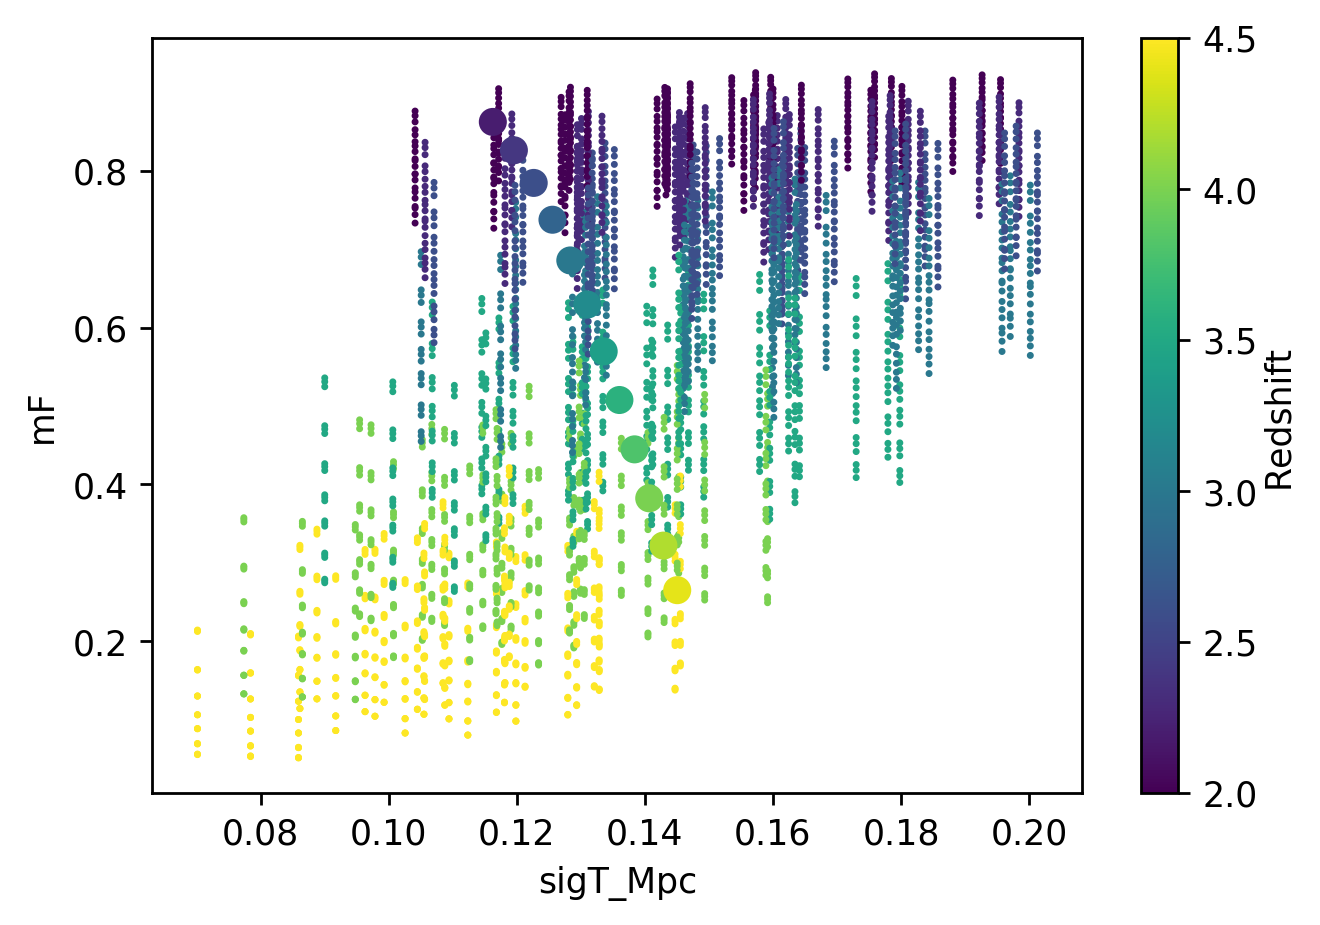

In [29]:
like.overplot_emulator_calls('sigT_Mpc','mF',linP_Mpc_params=linP_Mpc_params)

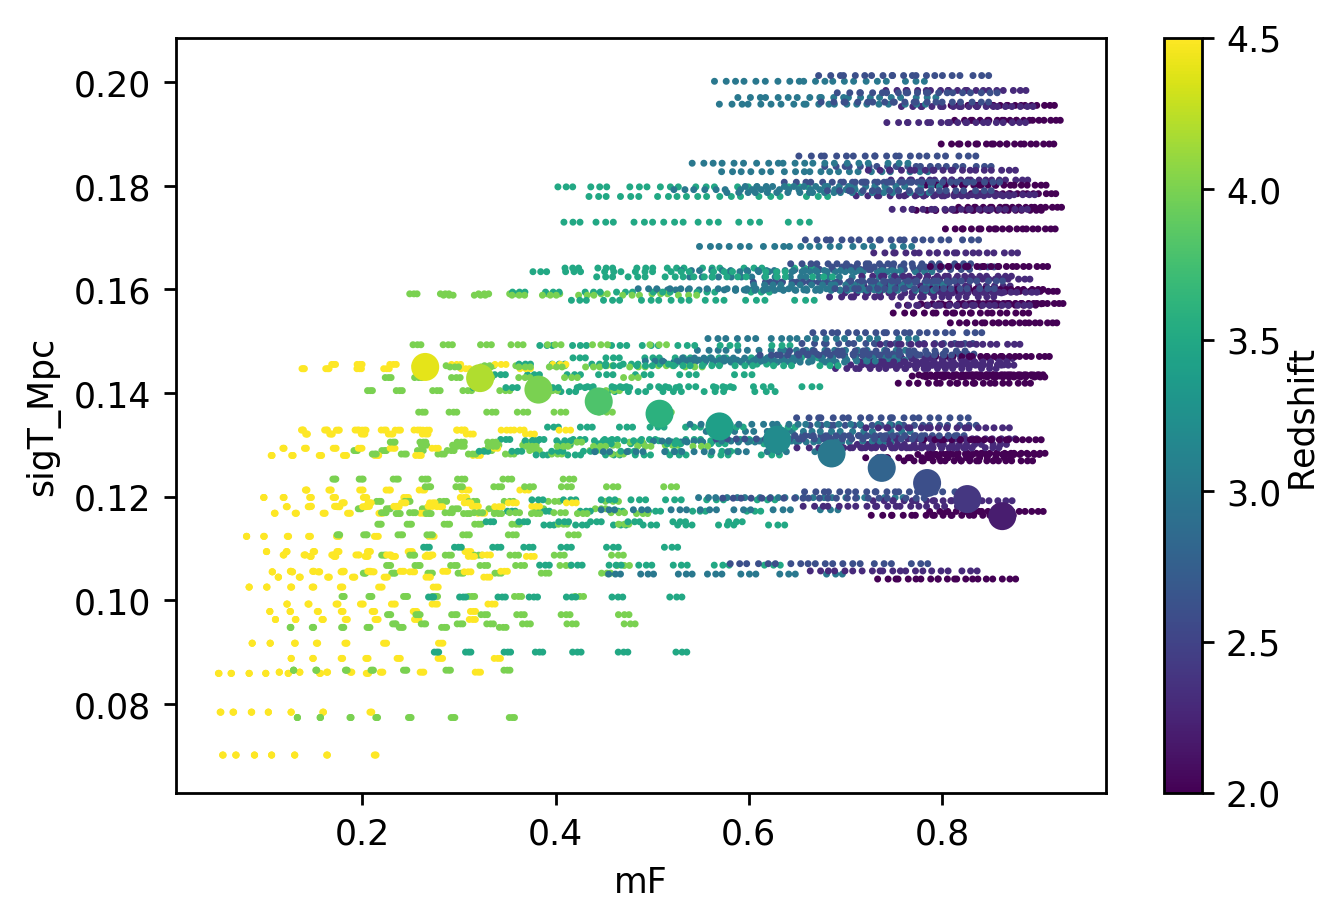

In [30]:
like.overplot_emulator_calls('mF','sigT_Mpc',linP_Mpc_params=linP_Mpc_params)